<a href="https://colab.research.google.com/github/rahool007/ML_attack_defense/blob/master/SR_RNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients
from sklearn.decomposition import PCA
from IPython.display import Image, display
from keras.preprocessing.sequence import TimeseriesGenerator
import seaborn as sns
from keras.backend import sign
import math

In [3]:
url = 'https://raw.githubusercontent.com/rahool007/Adverasrial-attacks-/main/Irradiance%20dataset.csv'
data = pd.read_csv(url) #read data
plt.rcParams["figure.figsize"] = (20,3)

#path = "/Users/rahulroy/Documents/ML and AI/Irradiance dataset.csv"
#data = pd.read_csv(path)       
data_AT = data["Avg Tower Dry Bulb Temp [deg C]"].values;
data_RH = data["Avg Tower RH [%]"].values      #access columns
data_WS = data["Avg Avg Wind Speed @ 6ft [m/s]"].values;
data_PR = data["Avg Station Pressure [mBar]"];
data_PP = data["Avg Precipitation [mm]"].values
data_SI = data["Avg Global CMP22 (vent/cor) [W/m^2]"].values
data=np.vstack((data_AT,data_RH,data_WS,data_PR,data_PP))    
data=data.T

#data pre-processing
scaler = StandardScaler()
data_standard = scaler.fit_transform(data)

#data_PE=data_PE.T
#train_test_split - Split arrays or matrices into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(data_standard, data_SI, test_size=0.33)  

# Data Processing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   DATE (MM/DD/YYYY)                    8783 non-null   object 
 1   HOUR-MST                             8783 non-null   object 
 2   Avg Tower Dry Bulb Temp [deg C]      8783 non-null   float64
 3   Avg Tower RH [%]                     8783 non-null   float64
 4   Avg Avg Wind Speed @ 6ft [m/s]       8783 non-null   float64
 5   Avg Station Pressure [mBar]          8783 non-null   float64
 6   Avg Precipitation [mm]               8783 non-null   float64
 7   Avg Global CMP22 (vent/cor) [W/m^2]  8783 non-null   float64
dtypes: float64(6), object(2)
memory usage: 549.1+ KB


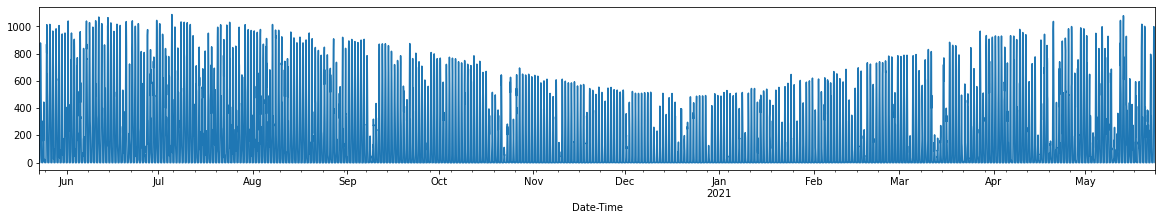

In [4]:
datas = pd.read_csv(url) ;
datas.info();
datas['Date-Time'] = datas['DATE (MM/DD/YYYY)'].str.cat(datas['HOUR-MST'],sep=" ");
datas['Date-Time'] = pd.to_datetime(datas['Date-Time'], infer_datetime_format=True);
datas.set_index('Date-Time')['Avg Global CMP22 (vent/cor) [W/m^2]'].plot();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   DATE (MM/DD/YYYY)                    8783 non-null   object        
 1   HOUR-MST                             8783 non-null   object        
 2   Avg Tower Dry Bulb Temp [deg C]      8783 non-null   float64       
 3   Avg Tower RH [%]                     8783 non-null   float64       
 4   Avg Avg Wind Speed @ 6ft [m/s]       8783 non-null   float64       
 5   Avg Station Pressure [mBar]          8783 non-null   float64       
 6   Avg Precipitation [mm]               8783 non-null   float64       
 7   Avg Global CMP22 (vent/cor) [W/m^2]  8783 non-null   float64       
 8   Date-Time                            8783 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 617.7+ KB


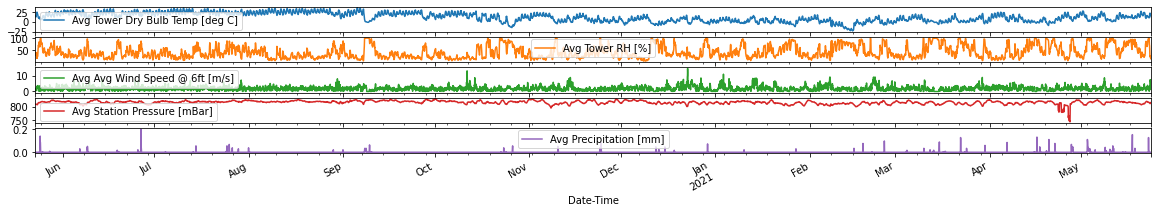

In [5]:
datas.info() 
#check missing data in file
datas.isna().sum()
datas.set_index('Date-Time')[['Avg Tower Dry Bulb Temp [deg C]','Avg Tower RH [%]','Avg Avg Wind Speed @ 6ft [m/s]','Avg Station Pressure [mBar]','Avg Precipitation [mm]']].plot(subplots=True);

### Multivariate Time series Modeling

In [6]:
#features=datas[['Date-Time','Avg Tower Dry Bulb Temp [deg C]','Avg Tower RH [%]','Avg Avg Wind Speed @ 6ft [m/s]','Avg Station Pressure [mBar]','Avg Precipitation [mm]']].to_numpy().tolist();
datas_input = datas[['Avg Global CMP22 (vent/cor) [W/m^2]','Avg Tower Dry Bulb Temp [deg C]','Avg Tower RH [%]','Avg Avg Wind Speed @ 6ft [m/s]','Avg Station Pressure [mBar]','Avg Precipitation [mm]']];
#datas.query("Avg Precipitation [mm] > 0")
datas_input = np.clip(datas_input, 0, 1000)
scaler = MinMaxScaler()
datas_scaled = scaler.fit_transform(datas_input)
features = datas_scaled
target = datas_scaled[:,0]
TimeseriesGenerator(features, target, length=2, sampling_rate=1, batch_size=1)[0]
#x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.01912786, random_state=123, shuffle=False)
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.01912786, random_state=123, shuffle=False)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)
win_length = 1          
batch_size = 32
num_features = 6
train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

x_train.shape =  (8615, 6)
y_train.shape =  (8615,)
x_test.shape =  (168, 6)
y_test.shape =  (168,)


### LSTM model architecture

In [7]:
# Fit and evaluate model
model = tf.keras.Sequential()    #sequential model instance
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))           #Leaky Rectified Linear Unit Activation function
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))     #reduce overfitting of the model to the training data
model.add(tf.keras.layers.Dense(1))          #interpret the features
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            69120     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 128)            131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1, 128)            0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=2,mode='min')
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=False, callbacks=[early_stopping])

Epoch 1/50
270/270 [==============================] - 6s 8ms/step - loss: 0.0352 - mean_absolute_error: 0.1169 - val_loss: 0.0192 - val_mean_absolute_error: 0.0919
Epoch 2/50
270/270 [==============================] - 1s 5ms/step - loss: 0.0128 - mean_absolute_error: 0.0767 - val_loss: 0.0191 - val_mean_absolute_error: 0.0941
Epoch 3/50
270/270 [==============================] - 1s 5ms/step - loss: 0.0125 - mean_absolute_error: 0.0759 - val_loss: 0.0181 - val_mean_absolute_error: 0.0901
Epoch 4/50
270/270 [==============================] - 2s 6ms/step - loss: 0.0124 - mean_absolute_error: 0.0750 - val_loss: 0.0177 - val_mean_absolute_error: 0.0898
Epoch 5/50
270/270 [==============================] - 2s 6ms/step - loss: 0.0122 - mean_absolute_error: 0.0746 - val_loss: 0.0170 - val_mean_absolute_error: 0.0852
Epoch 6/50
270/270 [==============================] - 2s 6ms/step - loss: 0.0123 - mean_absolute_error: 0.0745 - val_loss: 0.0169 - val_mean_absolute_error: 0.0859
Epoch 7/50
270/2

In [9]:
model.evaluate_generator(test_generator, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.016487183049321175, 0.08621183782815933]

In [10]:
test_generator

In [11]:
predictions = model.predict_generator(test_generator)
x_test_new = x_test[:,:][win_length:]
datas_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])],axis=1)
rev_trans = scaler.inverse_transform(datas_pred)
print(rev_trans)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[5.78576326e+00 1.09942000e+01 8.84200000e+01 8.64000000e-02
  8.16764200e+02 0.00000000e+00]
 [5.68800420e+00 1.09692000e+01 9.07417000e+01 2.52000000e-02
  8.16708800e+02 0.00000000e+00]
 [4.58130240e+00 1.08170000e+01 9.03017000e+01 5.26200000e-01
  8.16436100e+02 0.00000000e+00]
 ...
 [2.85461247e+01 1.34862000e+01 2.42388000e+01 2.15020000e+00
  8.15491500e+02 0.00000000e+00]
 [3.33324075e+01 1.26583000e+01 2.43497000e+01 3.26190000e+00
  8.16103100e+02 0.00000000e+00]
 [3.67380604e+01 1.19082000e+01 2.51333000e+01 1.75390000e+00
  8.16788100e+02 0.00000000e+00]]


### Predicted v/s Actual values of Solar Irradiance

In [12]:
datas_final = datas_input[predictions.shape[0]*-1:]
#print(datas_final.count())
datas_final['Solar Irrandiance Predicted'] = rev_trans[:,0]
#print(datas_final)
#datas_final[['Avg Global CMP22 (vent/cor) [W/m^2]','Solar Irrandiance Predicted']].plot()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
actual_data = datas_final.iloc[:,0];
predicted_data = datas_final.iloc[:,6];
lstm_score = r2_score(actual_data, predicted_data)
print("R^2 Score of LSTM model = ",lstm_score)


R^2 Score of LSTM model =  0.8069176281073076


In [14]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual solar data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted solar data')
    plt.title(title)
    plt.xlabel('Day')
    plt.ylabel('Solar Irradiance')
    plt.legend()
    plt.show()

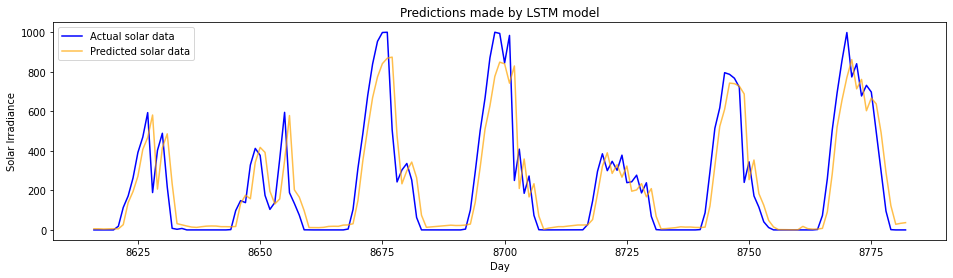

In [15]:
plot_predictions(actual_data, predicted_data, "Predictions made by LSTM model")

In [16]:
#import math
#math.sqrt(mean_squared_error(actual_data, predicted_data))

### FGSM Adversarial Attack

In [17]:
def fgsm_attack(data, epsilon, loss):
    # Collect the element-wise sign of the data gradient
    data_gradient = np.gradient(loss)
    sign_data_gradient = sign(data_gradient[0])
    #sign_data_gradient = np.reshape(sign_data_gradient, )
    perturbed_data = data + epsilon*sign_data_gradient
    return perturbed_data

In [18]:
y_target = y_test[predictions.shape[0]*-1:].reshape(-1,1)
loss = tf.square(rev_trans - y_target)
print(loss)
adversarial = fgsm_attack(x_test_new, 0.15, loss)
test_generator_adv = tf.keras.preprocessing.sequence.TimeseriesGenerator(adversarial, y_target, length=win_length, sampling_rate=1, batch_size=batch_size)

tf.Tensor(
[[3.34750565e+01 1.20872434e+02 7.81809640e+03 7.46496000e-03
  6.67103758e+05 0.00000000e+00]
 [3.23533917e+01 1.20323349e+02 8.23405612e+03 6.35040000e-04
  6.67013264e+05 0.00000000e+00]
 [2.09883317e+01 1.17007489e+02 8.15439702e+03 2.76886440e-01
  6.66567905e+05 0.00000000e+00]
 ...
 [8.14881235e+02 1.81877590e+02 5.87519425e+02 4.62336004e+00
  6.65026387e+05 0.00000000e+00]
 [1.11104939e+03 1.60232559e+02 5.92907890e+02 1.06399916e+01
  6.66024270e+05 0.00000000e+00]
 [1.34968508e+03 1.41805227e+02 6.31682769e+02 3.07616521e+00
  6.67142800e+05 0.00000000e+00]], shape=(167, 6), dtype=float64)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

R^2 Score of LSTM model =  0.6884479257803813


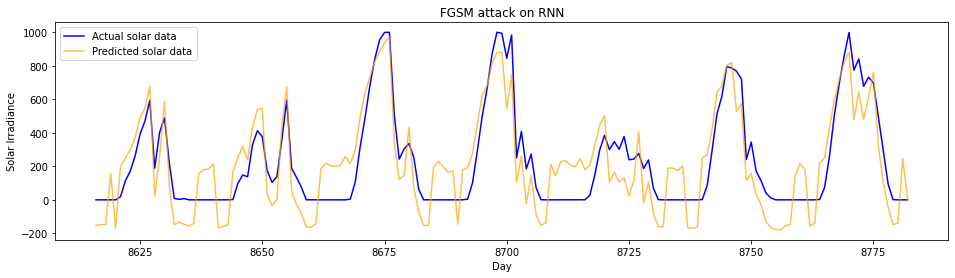

In [22]:
adversarial_prediction = model.predict_generator(test_generator_adv)
datas_pred_adv = pd.concat([pd.DataFrame(adversarial_prediction), pd.DataFrame(x_test[:,1:][win_length:])],axis=1)
rev_trans_adv = scaler.inverse_transform(datas_pred_adv)
datas_final['Adversarial Solar Irrandiance Predicted'] = rev_trans_adv[:,0]
datas_final['Adversarial Solar Irrandiance Predicted'] = datas_final['Adversarial Solar Irrandiance Predicted'].fillna(0)
predicted_data_adv = datas_final.iloc[:,7]
lstm_score = r2_score(actual_data, predicted_data_adv)
print("R^2 Score of LSTM model = ",lstm_score)
plot_predictions(actual_data, predicted_data_adv, "FGSM attack on RNN")

In [20]:
math.sqrt(mean_squared_error(actual_data, predicted_data))

128.40242683953255

In [21]:
math.sqrt(mean_squared_error(actual_data, predicted_data_adv))

163.1049881330355